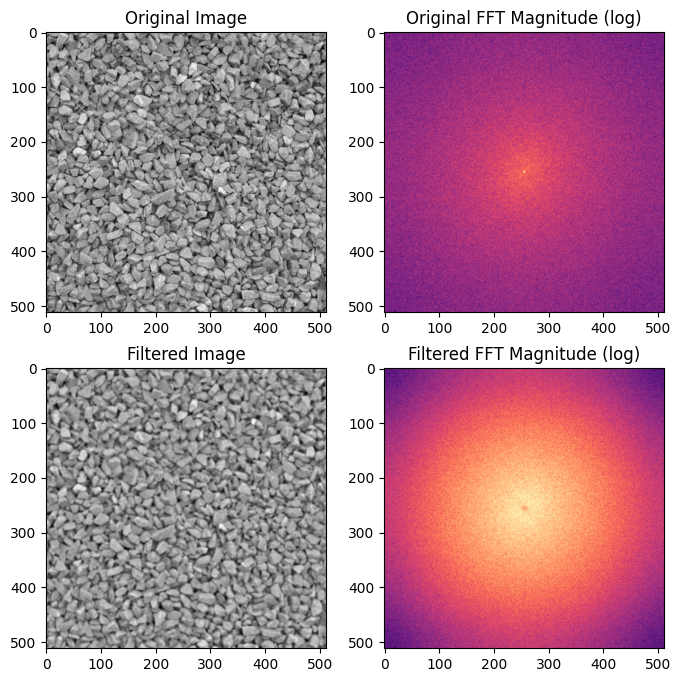

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import gravel
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift

image = gravel()
wimage = image * window('hann', image.shape)  # window image to improve FFT
filtered_image = difference_of_gaussians(image, 1, 12)
filtered_wimage = filtered_image * window('hann', image.shape)
im_f_mag = fftshift(np.abs(fftn(wimage)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(np.log(im_f_mag), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')
ax[1, 0].imshow(filtered_image, cmap='gray')
ax[1, 0].set_title('Filtered Image')
ax[1, 1].imshow(np.log(fim_f_mag), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')
plt.show()


Diffrence of gausian 
- applaing gusina blure with some  defition to blour image 
- the same with some scaller for difation 
- dwa zblurowane zdjęcia z czego jedno jest bardziej zblurowane od grugiego 
- odejmujem te dwa zdjęcia i mamy adge lines 
- (potem można binaryzacje z jakimś treschold)
- czyli wykrywa miejsca o wysokim kontraście które z reguły są wierzchołami/liniami 
 - problem z tym że też wykrywa noise 

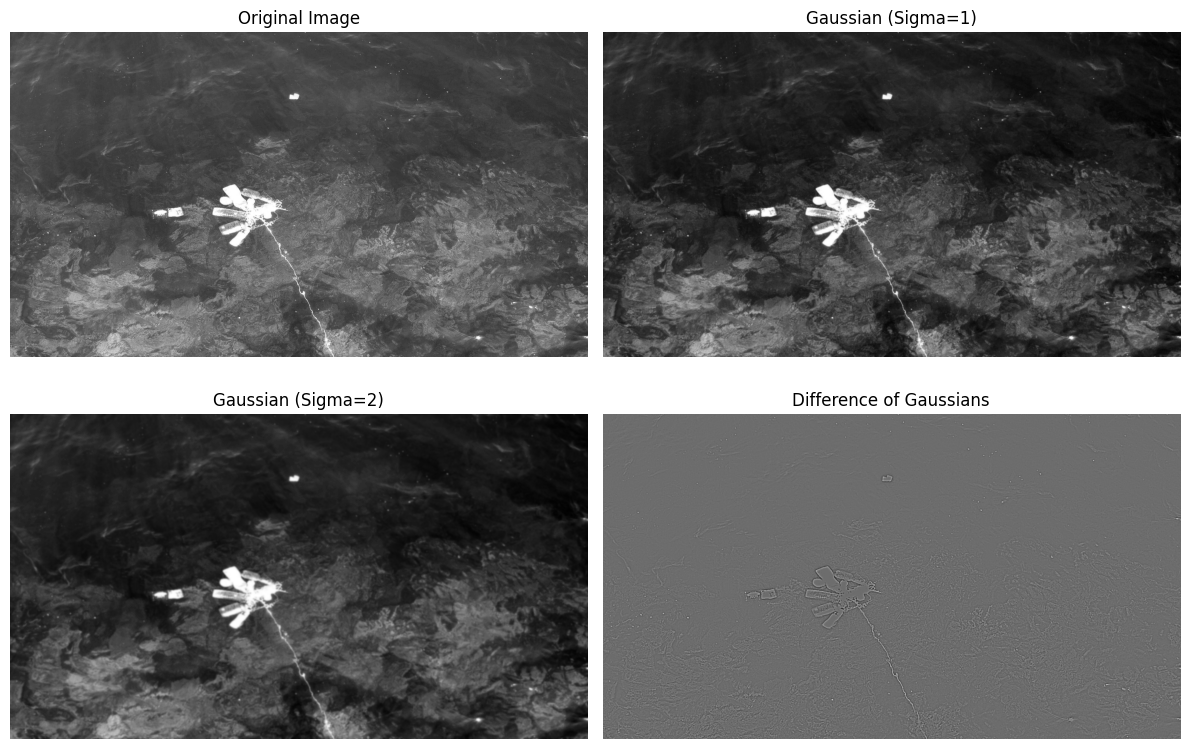

In [7]:
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from skimage.filters import gaussian, difference_of_gaussians

image = io.imread('Dataset/training/train_image1.JPG')

gray_image = color.rgb2gray(image)

# Step 3: Convert the image to float format
float_image = img_as_float(gray_image)

# Step 4: Apply Gaussian blurring with different sigma values
sigma1 = 1  # Sigma value for the first Gaussian blur
sigma2 = 2  # Sigma value for the second Gaussian blur
gaussian1 = gaussian(float_image, sigma=sigma1)
gaussian2 = gaussian(float_image, sigma=sigma2)

# Step 5: Compute the difference of Gaussians
dog_image = difference_of_gaussians(float_image, sigma1, sigma2)

# Step 6: Display the original image, Gaussian blurred images, and the difference of Gaussians
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Changed figsize to accommodate two rows
ax = axes.ravel()

ax[0].imshow(float_image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(gaussian1, cmap='gray')
ax[1].set_title('Gaussian (Sigma={})'.format(sigma1))

ax[2].imshow(gaussian2, cmap='gray')
ax[2].set_title('Gaussian (Sigma={})'.format(sigma2))

ax[3].imshow(dog_image, cmap='gray')
ax[3].set_title('Difference of Gaussians')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


 SIFT descriptor to create gradient histograms
 HOG 
 - feture extraction 
 - 

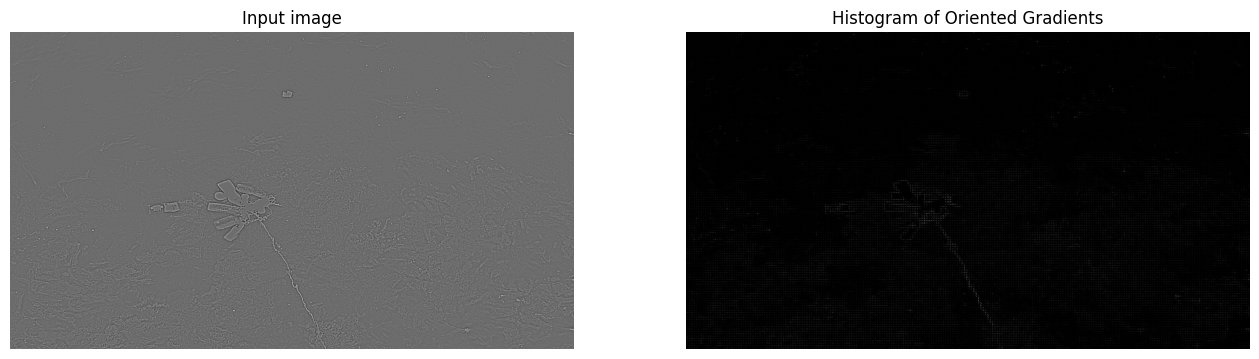

In [11]:
from skimage.feature import hog
from skimage import exposure


fd, hog_image = hog(dog_image, visualize=True, block_norm='L2-Hys')

# fd, hog_image = hog(dog_image, orientations=8, pixels_per_cell=(16, 16),
                    # cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(dog_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

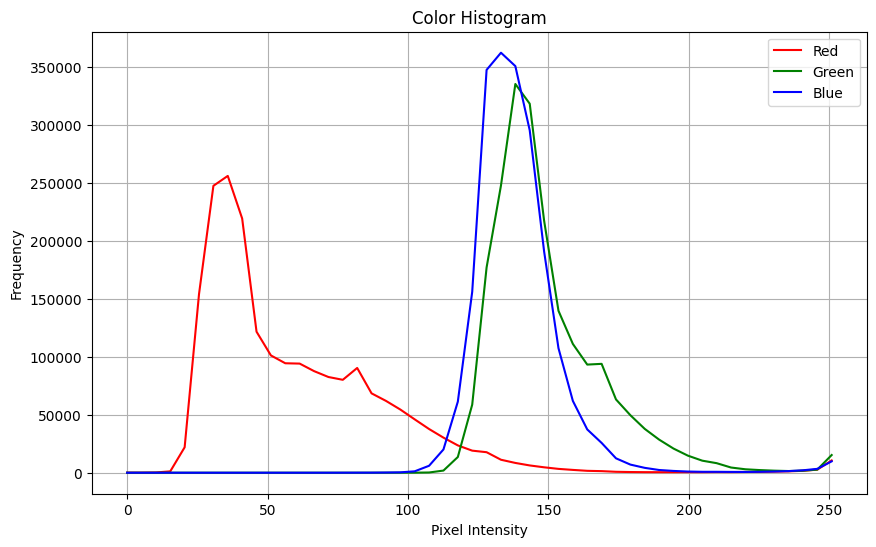

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

# Step 1: Read the input image
image = io.imread('Dataset/training/train_image1.JPG')

# Step 2: Compute color histograms for each channel (R, G, B)
hist_r, bins_r = np.histogram(image[:, :, 0], bins=50, range=(0, 256))
hist_g, bins_g = np.histogram(image[:, :, 1], bins=50, range=(0, 256))
hist_b, bins_b = np.histogram(image[:, :, 2], bins=50, range=(0, 256))

# Step 3: Plot the color histograms
plt.figure(figsize=(10, 6))
plt.plot(bins_r[:-1], hist_r, color='r', label='Red')
plt.plot(bins_g[:-1], hist_g, color='g', label='Green')
plt.plot(bins_b[:-1], hist_b, color='b', label='Blue')
plt.title('Color Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
